In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [2]:
DATA_DIR = "/home/n.anokhin/data/msd/"
TRACKS = 50_000

## Read and preprocess data

### Usage data

In [3]:
# http://millionsongdataset.com/tasteprofile/#getting
raw_data = pd.read_csv(DATA_DIR + "raw/train_triplets.txt", sep="\t", names=["user_id", "song_id", "play_count"])
raw_data = raw_data[raw_data["play_count"] > 1].copy()

In [4]:
top_songs = raw_data["song_id"].value_counts()[:TRACKS].astype(float)
top_songs_data = raw_data[raw_data["song_id"].isin(top_songs.index)].copy()

In [5]:
user_song_counts = top_songs_data["user_id"].value_counts()
top_users = user_song_counts[user_song_counts >= 20]

In [6]:
data = top_songs_data[top_songs_data["user_id"].isin(top_users.index)].copy()
data["test"] = np.random.random(len(data)) < 0.2

In [7]:
dataset = ld.Dataset()
dataset.fit(data["user_id"], data["song_id"])

len(dataset.mapping()[0]), len(dataset.mapping()[2])

(264428, 50000)

### Track metadata

In [8]:
# http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt
meta = pd.read_csv(
    DATA_DIR + "raw/unique_tracks.txt", 
    sep="<SEP>", 
    engine="python", 
    names=["track_id", "song_id", "artist", "title"]
)

# http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls
genre = pd.read_csv(
    DATA_DIR + "raw/ifs.tuwien.ac.at_mir_msd_partitions_msd-MAGD-genreAssignment.cls.txt", 
    sep="\t", 
    header=None, 
    names=["track_id", "genre"],
)

meta = (
    pd.merge(meta, genre, left_on="track_id", right_on="track_id", how="left")
        .set_index("song_id")
        .drop("track_id", axis=1)
        .groupby(level=0)
        .last()
        .loc[top_songs.index]
)

top_songs_meta = pd.merge(
    pd.merge(meta, top_songs.to_frame("pop"), right_index=True, left_index=True),
    pd.Series(dataset.mapping()[2]).to_frame("track"), 
    right_index=True, 
    left_index=True, 
    how="left",
).sort_values("pop", ascending=False)

# Check that every track has meta
assert pd.isna(top_songs_meta["track"]).sum() == 0 

# Check all tracks are there
assert sorted(top_songs_meta["track"]) == list(range(TRACKS))

top_songs_meta.to_json(DATA_DIR + "processed/tracks.json", lines=True, orient="records")

top_songs_meta.head(5)

,artist,title,genre,pop,track
SOFRQTD12A81C233C0,Harmonia,Sehr kosmisch,Pop_Rock,65688.0,7
SOAUWYT12A81C206F1,Björk,Undo,None,57660.0,0
SOBONKR12A58A7A7E0,Dwight Yoakam,You're The One,Country,55035.0,2
SOAXGDH12A8C13F8A1,Florence + The Machine,Dog Days Are Over (Radio Edit),None,52773.0,1
SOSXLTC12AF72A7F54,Kings Of Leon,Revelry,Pop_Rock,48290.0,15


## Train embeddings model

In [9]:
train_data = data[~data["test"]]
test_data = data[data["test"]]

In [10]:
train_interactions, _ = dataset.build_interactions(train_data[["user_id", "song_id"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user_id", "song_id"]].itertuples(index=False, name=None))

In [11]:
def fit_model(epochs=1, at=10, no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss="warp",
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    no_components = trial.suggest_categorical("no_components", [30, 50, 100])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10, 
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [12]:
best_params = {
    'no_components': 100,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.01
}

In [ ]:
model, precisions_at = fit_model(
    epochs=400,
    at=10,
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.02194851264357567 +/- 0.00025050841951650366
1:	0.024220090359449387 +/- 0.0002659781946966547
2:	0.02695455774664879 +/- 0.0002812117475619147
3:	0.02931598387658596 +/- 0.00029397614033479873
4:	0.03168954700231552 +/- 0.00030306040667067377
5:	0.033924736082553864 +/- 0.00031288401928171894
6:	0.03624219074845314 +/- 0.00032250635387553805
7:	0.03817939758300781 +/- 0.00033021639092358
8:	0.039877403527498245 +/- 0.0003365679790623114
9:	0.04136764630675316 +/- 0.0003425606275641644
10:	0.04275971278548241 +/- 0.0003478615268244448
11:	0.044085435569286346 +/- 0.00035301340813186706
12:	0.04539484530687332 +/- 0.00035804751947921725
13:	0.04646998643875122 +/- 0.00036233534687147044
14:	0.04771268740296364 +/- 0.00036734486357481715
15:	0.0488833524286747 +/- 0.00037159558575270666
16:	0.050102923065423965 +/- 0.00037612097181623027
17:	0.0511932335793972 +/- 0.0003807042761338984
18:	0.05234569311141968 +/- 0.00038530734146611275
19:	0.05339125916361809 +/- 0.00038908866135746

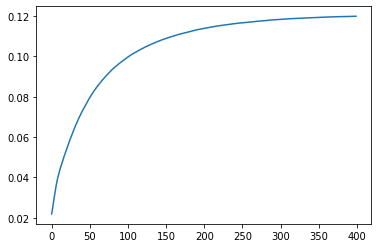

In [15]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings for the simulator

In [17]:
biases, embeddings = model.get_item_representations()

In [18]:
columns = ["artist", "title", "track", "genre"]

writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(
    embeddings, 
    metadata=list(top_songs_meta[columns].sort_values("track").itertuples(index=False, name=None)), 
    tag="msd", 
    metadata_header=columns
)
writer.close()

In [19]:
np.save(DATA_DIR + "processed/tracks", embeddings)

## Sample and save user tastes

In [20]:
track_freq = top_songs_meta[["track", "pop"]].copy().set_index("track")

In [21]:
num_users = 10_000
num_interests = 3

users = []
for j in tqdm.trange(num_users):
    interests = track_freq.sample(n=num_interests, weights="pop").index.values.tolist()
    
    consume_bias = np.random.uniform(0, 10)
    consume_sharpness = np.power(np.random.uniform(1, 2), np.random.choice([1, -1]))
    
    users.append({
        "user": j,
        "interests": interests,
        "consume_bias": consume_bias,
        "consume_sharpness": consume_sharpness
    })

100%|██████████| 10000/10000 [00:40<00:00, 245.51it/s]


In [22]:
with open(DATA_DIR + "processed/users.json", "w") as users_file:
    for user in users:
        users_file.write(json.dumps(user) + "\n")

## Visualize embeddings distribution

In [23]:
n = 30
sample_tracks = np.random.choice(np.arange(embeddings.shape[0]), n)

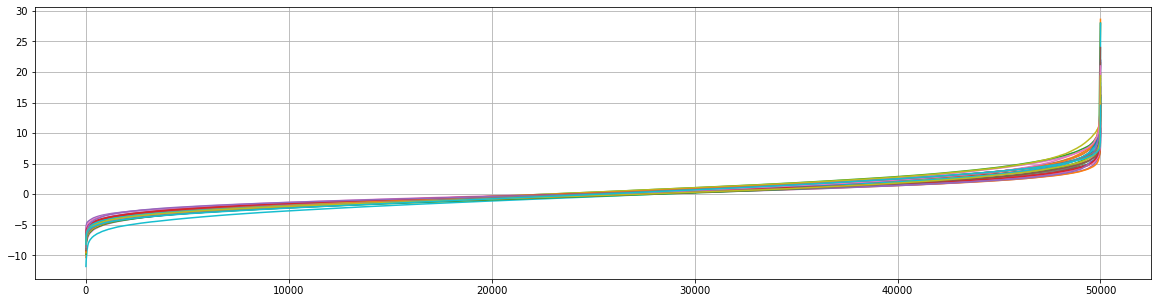

In [24]:
dots = np.dot(embeddings[sample_tracks], embeddings.T)

x = np.arange(embeddings.shape[0])

fig, ax = pl.subplots(figsize=(20, 5))

for j in range(n):
    y = np.sort(dots[j])
    ax.plot(x, y)
    
ax.grid()

pass